<a href="https://colab.research.google.com/github/manojkyresearch006/Image-Classification-Colab-and-PyTorch/blob/main/train_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch
!pip install torchvision

In [2]:
#!git clone https://github.com/manojkyresearch006/Image-Classification-Colab-and-PyTorch.git
import sys
sys.path.append("Image-Classification-Colab-and-PyTorch")

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
import numpy as np

In [4]:

train_transform=transforms.Compose(
    [transforms.RandomCrop(32),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

valid_transform=transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
valset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=valid_transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=valid_transform)
valid_size=0.1
num_train = len(trainset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))
train_indices=indices[split:]
valid_indices=indices[:split]
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)




trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=train_sampler,num_workers=2)

valloader= torch.utils.data.DataLoader(valset, batch_size=batch_size, sampler=valid_sampler,num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


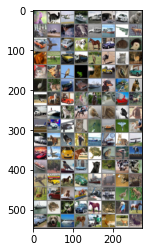

 bird   cat plane  ship truck plane   car   dog  deer plane   cat  bird plane  ship plane  deer   car plane   car   dog horse   car   cat   dog   cat  deer   car truck  deer  bird   cat  deer   cat  deer  bird  frog   cat truck   cat   car  bird  deer  ship   car  ship   dog  bird horse  deer horse   car  bird   cat  bird  ship  bird truck  ship   dog horse  bird  frog   cat   dog plane   car  ship   cat  bird  ship plane   dog truck horse   dog  bird  ship  ship   cat plane   car plane   car horse  frog   cat  bird  bird  ship  deer  bird   car   dog  deer horse  frog plane   car horse   car  ship truck   cat  frog  deer   car   cat  ship   dog  ship  bird  frog  ship  frog  frog   car horse  frog  bird horse   car   dog  ship   dog truck  deer  deer  deer


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))


In [6]:

from model import *
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [7]:
print("Number of GPU's available are {}".format(torch.cuda.device_count()))
print("Name of the GPU available is {}".format(torch.cuda.get_device_name(0)))
dev=torch.device('cuda:0')
net=net.to(dev)

Number of GPU's available are 1
Name of the GPU available is Tesla P4


In [8]:
num_epochs=100
num_batches=len(trainloader)
train_len=batch_size*num_batches

In [9]:
def softmax(output):
  #num=np.exp(output)
  #denom=np.sum(num,axis=0)
  #shape=denom.shape[0]
  #denom=np.reshape(denom,(shape,1))
  #return num/denom
  func=torch.nn.Softmax(dim=1)
  return func(output)

def validation(loader,Model):
  total=0
  all_correct=0
  batch_loss=0
  num_val_batches=len(loader)
  with torch.no_grad():
    for j, data in enumerate(loader,0):
      inputs,labels=data
      inputs=inputs.to(dev)
      labels=labels.to(dev)
      outputs=Model(inputs)
      val_loss=criterion(outputs,labels)
      batch_loss=batch_loss+val_loss.item()
      #outputs_cpu=softmax(outputs.cpu())
      #preds=torch.argmax(outputs_cpu,dim=1).numpy()
      _, val_preds = torch.max(outputs,1)
      all_correct += torch.sum(val_preds == labels.data)
      labels=labels.cpu().numpy()
      total=total+len(labels)
      #correct=(preds==labels).sum()
      #all_correct=all_correct+correct
  accuracy=all_correct/total
  validation_loss=batch_loss/num_val_batches
  return [accuracy,validation_loss]
      

In [10]:
train_loss=[]
val_loss=[]
val_accuracy=[]
train_accuracy=[]
for epoch in range(num_epochs):  # loop over the dataset multiple times
    correct=0
    total=0
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs=inputs.to(dev)
        labels=labels.to(dev)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, _preds = torch.max(outputs,1)
        correct += torch.sum(_preds == labels.data)
        total += len(labels.cpu().numpy())
        # print statistics
        running_loss += loss.item()
    taccuracy=correct/total
    accuracy,validation_loss=validation(valloader,net)
    running_loss=running_loss/num_batches
    train_loss.append(running_loss)
    val_loss.append(validation_loss)
    val_accuracy.append(accuracy)
    train_accuracy.append(taccuracy)
    print("Epoch={},Loss= {},accuracy={},val loss= {} and val accuracy={} ".format(epoch,running_loss,taccuracy,validation_loss,accuracy))
print('Finished Training')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch=0,Loss= 2.161131028085947,accuracy=0.18735556304454803,val loss= 1.9552115559577943 and val accuracy=0.2606000006198883 
Epoch=1,Loss= 1.842811126939275,accuracy=0.2996889054775238,val loss= 1.7559043347835541 and val accuracy=0.33640000224113464 
Epoch=2,Loss= 1.6842177479781888,accuracy=0.3698444366455078,val loss= 1.6507037907838822 and val accuracy=0.39499998092651367 
Epoch=3,Loss= 1.583623037419536,accuracy=0.41100001335144043,val loss= 1.5380419224500657 and val accuracy=0.43039998412132263 
Epoch=4,Loss= 1.4938853250985795,accuracy=0.4516666829586029,val loss= 1.462698942422867 and val accuracy=0.47099998593330383 
Epoch=5,Loss= 1.430227663029324,accuracy=0.4807555675506592,val loss= 1.4064468935132026 and val accuracy=0.4909999966621399 
Epoch=6,Loss= 1.3668698096139864,accuracy=0.5096666812896729,val loss= 1.3626066148281097 and val accuracy=0.517799973487854 
Epoch=7,Loss= 1.3305581371215256,accuracy=0.5232222080230713,val loss= 1.321657943725586 and val accuracy=0.537

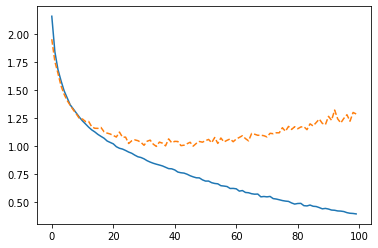

In [11]:
Epochs=np.arange(num_epochs)
plt.plot(Epochs,train_loss)
plt.plot(Epochs,val_loss,'--')

In [12]:
print(validation(testloader,net))

[tensor(0.6703, device='cuda:0'), 1.3504279746284968]
